In [5]:
# Visualization
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
# Modules for loading dataset
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

# Custom Modules
from found import found
from models.VGG13 import VGG13
from models.DataLoader import FaceDataset

# Load Dataset for Watermarking

In [6]:
'''
Sets up the dataset to be watermarked
'''

# Instantiate Variable

SEED = 42
ROOT_PATH = "/home/ychien13/my_github/CSE467_Privacy/Image_Poisoning/data/raw/Images"
IN_CHANNELS = 3
OUT_CHANNELS = 3

# Check if nvidia GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224),antialias=True)
])

# Initializing Datasets
dataset = FaceDataset(ROOT_PATH,transform)
generator = torch.Generator().manual_seed(SEED)

train_data,attack_data, test_data = random_split(dataset,[0.7,0.1,0.2], generator=generator)

# Batch 1 because each image need to be handle independently
attack_loader = DataLoader(attack_data, batch_size=1, shuffle=True, generator=generator)

print(f"Attack dataset: {len(attack_loader)}")

Attack dataset: 500


# Testing with One image

In [7]:
model = VGG13(IN_CHANNELS,OUT_CHANNELS).to(device)

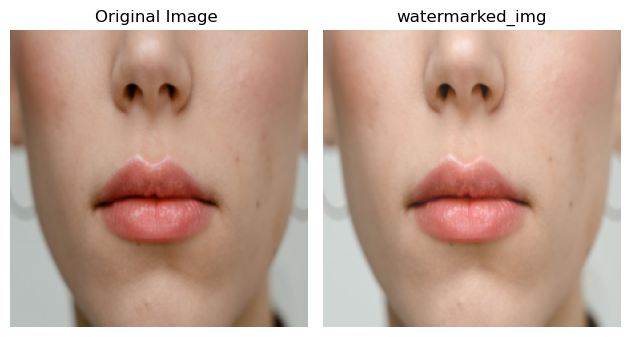

In [8]:
img, lable = next(iter(attack_loader))

fig, axes = plt.subplots(nrows=1,ncols=2)

watermarked_img = found(model,img)

axes[0].imshow(img[0].permute((1,2,0)))
axes[0].set_title("Original Image ")
axes[0].axis("off")

axes[1].imshow( np.clip( watermarked_img[0].permute((1,2,0)),a_min=0,a_max=1) )
axes[1].set_title("watermarked_img")
axes[1].axis("off")

plt.tight_layout()
plt.show()

# Testing watermark effect on model

In [9]:
model.load_state_dict(torch.load("/home/ychien13/my_github/CSE467_Privacy/Image_Poisoning/src/checkpoints/model.pth"))

<All keys matched successfully>

In [13]:
watermark_img_score = 0
base_img_score = 0
total = 0

for img, label in tqdm(attack_loader):

    watermarked_img = found(model,img,limit=0.1)

    # Loading the images onto gpu
    watermarked_img = watermarked_img.to(device)
    img = img.to(device)
    
    label = label.to(device)

    # Zip together image for inference
    batch = torch.stack((img.squeeze(0), watermarked_img.squeeze(0)))

    # Inference 
    output = model(batch)

    base_img_score += (output[0].argmax() == label).sum().item()
    watermark_img_score += (output[1].argmax() == label).sum().item()
    total+=1
                   


print(f"Model Accuracy on original Images: {base_img_score}/{total} | {base_img_score/total:.2f}")
print(f"Model Accuracy on Watermark Images: {watermark_img_score}/{total} | {watermark_img_score/total:.2f}")

100%|██████████| 500/500 [00:40<00:00, 12.49it/s]

Model Accuracy on original Images: 270/500 | 0.54
Model Accuracy on Watermark Images: 258/500 | 0.52
